In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Define data paths

In [2]:
data_dir = os.path.expanduser('~/Google Drive/Bas Zahy Gianni - Games/Data/2_eye/New')
game_dir = os.path.join(data_dir, 'game')
eyet_dir = os.path.join(data_dir, 'eyet')
mous_dir = os.path.join(data_dir, 'mous')
output_dir = os.path.expanduser('~/Google Drive/Bas Zahy Gianni - Games/Analysis/2_eye/histograms')
game_files = [os.path.join(game_dir, g) for g in os.listdir(game_dir) if g[-3:]=='csv']
eyet_files = [os.path.join(eyet_dir, e) for e in os.listdir(eyet_dir) if e[-3:]=='csv']
mous_files = [os.path.join(mous_dir, m) for m in os.listdir(mous_dir) if m[-3:]=='csv']

# Load data

Notes:

1. Computer logs timestamps as "0", so when computer makes last move, we lose time index
2. Solution: load raw game data with "ready" entries, as these have timestamp for game beginning.
3. Now requires further processing :(

In [3]:
subject_initial_map = [g[-6:-4] for g in game_files]       # get alphabetical list of subject initials from filenames
subject_initial_map = dict(zip(subject_initial_map, np.arange(len(subject_initial_map))))
                                                           # map initials to ordinal indices
top = 192                                                  # board bounds and dimensions in pixels
bottom = 506
left = 177
right = 889
width = right - left
height = bottom - top

def mouse_x_to_tile(x):
    """Converts mouse x coordinates to board-space"""
    return 9*(x - left) / width

def mouse_y_to_tile(y):
    """Converts mouse y coordinates to board-space"""
    return 4*(y - top) / height

def expand_mouse_mt(row):
    """Appends start time, end time to mouse timestamp records for a single record"""
    
    endtime = int(row['ts'])                               # get turn end timestamp
    starttime = endtime - int(row['rt'])                   # get turn start from turn end and turn duration
    if type(row['mt'])==str:                               # check if valid data
        return str(starttime) + ',' + row['mt'] + ',' + str(endtime)
                                                           # add start, end times to respective ends of record
    
def expand_mouse_mx(row):
    """Appends start time location, end time location to mouse spatial coordinates for a single record"""
    
    endtime = int(row['ts'])                               # get turn end timestamp
    starttime = endtime - int(row['rt'])                   # get turn start from turn end and turn duration
    if type(row['mx'])==str:                               # check if valid data
        locs = row['mx'].split(';')                        # split record into (x, y) pair strings
        endloc = locs[-1]                                  # select first and last coordinate pairs
        startloc = locs[0]
        return startloc + ';' + row['mx'] + ';' + endloc    # add start, end coords to respective ends of record
    
def fix_game_boards(row):
    """Removes move from appropriate color board string representation for a single record"""
    
    bp, wp = row[['bp', 'wp']]                              # select board string reps
    if row['color']==0:                                     # if Black is player
        p = list(bp)                                        # convert board string to list (mutability)
        p[int(row['zet'])] = '0'                            # set list at zet loc to be '0'
    else:                                                   # if White is player, do the same thing for White's board
        p = list(wp)
        p[int(row['zet'])] = '0'

    return ''.join(p)                                       # rejoin into new string

In [4]:
def load_game_file(gf):
    """Loads and preprocesses data from game observations"""
    
    gfnames = [
        'idx', 'id', 'color', 'gi', 'mi', 
        'status', 'bp', 'wp', 'zet', 
        'rt', 'ts', 'mt', 'mx'
    ]                                                      # names for columns

    D = pd.read_csv(gf, names=gfnames)                     # load csv into pandas dataframe
    readyfilter = D['status'] == 'ready'                   # filter on convenience records
    rtfilter = D['rt'] == 0                                # filter on AI moves
    aifilter = ~(readyfilter & rtfilter)                   # filter out convenience AI records
    D = D.loc[aifilter]                                    # apply filter
    D.loc[readyfilter, 'rt'] = 0                           # set human convenience records rt field to 0
    D['subject'] = gf[-6:-4]                               # set subject field to initials in game file name
    D['human'] = D['subject'].map(subject_initial_map)     # set human field to be subject index (alphabetical)
    D['move_start_ts'] = (D['ts'] - D['rt']).shift(-1)     # set move_start_timestamp field to turn beginning
    tsfilter = rtfilter | readyfilter                      # filter on ai OR convenience records
    D.loc[tsfilter, 'ts'] = D.loc[tsfilter, 'movestart_ts']       
                                                           # replace invalid timestamps with inferred correct timestamp
    D['mx'] = D.apply(expand_mouse_mx, axis=1)             # append move start and end mouse spatial coords
    D['mt'] = D.apply(expand_mouse_mt, axis=1)             # append move start and end timestamps to mouse timestamps
    D['is human'] = 1                                      # initialize human player indicator variable
    playfilter = D['status'].isin(['playing', 'win', 'draw'])
                                                           # filter on non-convenience records
    D.loc[playfilter & rtfilter, 'is human'] = 0           # set human player indicator to 0 on AI records
    endfilter = D['status'].isin(['win', 'draw'])          # filter on game end records
    idx = D.loc[c].index                                   # get indices for game end filter application
    if D.loc[idx[-1], 'rt'] != 0:                          # if human player ended last game
        D.loc[idx[-1], 'gi'] = D.loc[idx[-1], 'gi'] - 1    # subtract 1 from game index (why? probably a data error)
    bpfilter = D['color']==0                               # filter on player colors
    wpfilter = D['color']==1
    D.loc[bpfilter, 'bp'] = D.loc[bpfilter].apply(fix_game_boards, axis=1)
    D.loc[wpfilter, 'wp'] = D.loc[wpfilter].apply(fix_game_boards, axis=1)
                                                           # apply filters and remove last move from board
    return D.set_index('ts')                               # set index to timestamps

def load_mouse_file(mf):
    """Loads and preprocesses mouse tracking data"""
    
    mfnames = [
        'idx', 'id', 'color', 'gi', 'mi', 
        'status', 'bp', 'wp', 'zet', 
        'rt', 'ts', 'mt', 'mx'
    ]                                                      # names for columns
    
    D = pd.read_csv(mf, names=mfnames)                     # load csv into pandas dataframe
    D['mx'] = D.apply(expand_mouse_mx, axis=1)             # append start and end mouse spatial coords
    D['mt'] = D.apply(expand_mouse_mt, axis=1)             # append start and end mouse timestamps
    D = D[['mt', 'mx']]                                    # lose the fluff
    
    valid = pd.notnull(D['mt'])                            # select records with valid mouse time series
    m = (D.loc[valid, 'mt'] + ',').sum().split(',')[:-1]   # combine all mouse timestamp records
    x = [tuple(xy.split(',')) for xy in (D.loc[valid, 'mx'] + ';').sum().split(';')][:-1]
                                                           # combine all mouse coordinate records
    M = pd.DataFrame(index=m, data=x, columns=['x', 'y'])  # new dataframe with timestamp index and coordinates
    M['subject'] = mf[-6:-4]                               # set subject field to initials
    M['human'] = M['subject'].map(subject_initial_map)     # set human field to subject ordinal index
    M.index = M.index.astype(int)                          # cast timestamp index to integers
    return M

def load_eyetracker_file(ef):
    """Loads and preprocesses eyetracker data"""
    D = pd.read_csv(ef)                                    # load EL data into pandas dataframe
    D['subject'] = ef[-6:-4]                               # set subject field to initials
    D['human'] = D['subject'].map(subject_initial_map)     # set human field to subject ordinal index
    D[['start', 'end']] = (D[['start', 'end']]*1000).astype(int)
                                                           # set start and end fields to ms resolution, integers
    return D[['start', 'end', 'transx', 'transy', 'human']].set_index('start')
                                                           # lose the fluff; index by start timestamp
def make_tidy(subject_index):
    """
    Produces a combined dataframe of mouse and eye coordinates, indexed by timestamp
    
    Should consider modifying to not use e_list, m_list, and g_list, but rather to take
    e, m, g as args
    """
    e, m, g = [l[subject_index] for l in [e_list, m_list, g_list]]
                                                           # get appropriate dataframe for each subject
    start_time = int(e.index[0])                           # get the eyetracker start time
    end_time = int(e.loc[e.index.values[-1], 'end'])       # get the eyetracker end time
    mbounds = (m.index >= start_time) & (m.index <= end_time)
                                                           # filter on mouse records within EL record bounds
    m = m.loc[mbounds]                                     # apply filter
    idx = np.arange(start_time, end_time, 1)               # prepare index for new dataframe
    D = pd.DataFrame(index=idx)                            # new dataframe for tidy timeseries
    D.loc[e.index, 'eyex'] = e['transx'].astype(float)     # get valid eye coordinates in board space
    D.loc[e.index, 'eyey'] = e['transy'].astype(float)
    D.loc[e.index, 'eyeflag'] = 1                          # indicator for eye event
    
    D.loc[m.index, 'moux'] = m['x'].astype(float).map(mouse_x_to_tile)
                                                           # get valid mouse coords and map to board space
    D.loc[m.index, 'mouy'] = m['y'].astype(float).map(mouse_y_to_tile)
    D.loc[m.index, 'mouflag'] = 1                          # indicator for mouse event
    
    _sl = g.loc[g.index > start_time, :]                   # selector for valid game events
    
    D.loc[_sl.index, 'turn'] = 100*_sl['gi'] + _sl['mi']   # unique id for turns for valid game events
    D.loc[_sl.index, 'task'] = _sl['status']               # task indicator
    
    D = D.dropna(how='all')                                # shrink dataframe by pruning all event-less records
    
    fillcols = [
        'eyex', 'eyey', 
        'moux', 'mouy', 
        'turn', 'task'
    ]                                                      # fields to fill forward
    
    D[fillcols] = D[fillcols].fillna(method='ffill')       # fill forward
    
    D['ts'] = D.index                                      # convenience field of timestamps
    D.loc[D['eyeflag']==1, 'eyedur'] = D.loc[D['eyeflag']==1, 'ts'].diff(periods=1)
                                                           # set duration for each event of each type
    D.loc[D['mouflag']==1, 'moudur'] = D.loc[D['mouflag']==1, 'ts'].diff(periods=1)
                               
    D['eyetile'] = D['eyex'] + 9*D['eyey']                 # convert board coordinates to tile index
    D['moutile'] = D['moux'] + 9*D['mouy']
    D.loc[D['eyeflag']==1, 'eyetile'] =  D.loc[D['eyeflag']==1, 'eyetile'].astype(int)
                                                           # cast valid values to int (np.nan is float)
    D.loc[D['mouflag']==1, 'moutile'] =  D.loc[D['mouflag']==1, 'moutile'].astype(int)

    return D

In [5]:
e_list = [load_eyet_file(e) for e in eyet_files]
m_list = [load_mous_file(m) for m in mous_files]
g_list = [load_game_file(g) for g in mous_files]

t = [make_tidy(i) for i in range(len(e_list))]

mpivs = []
epivs = []
for i in range(len(m_list)):
    
    # mouse histograms
    m = m_list[i]
    g = g_list[i]
    g['turn'] = 100*g['gi'] + g['mi']
    gp = g.loc[g['status'].isin(['playing', 'draw', 'win'])]
    m['turn'] = np.nan
    m['turnstart'] = np.nan
    m['turnend'] = np.nan
    m['ts'] = m.index
    m['xtile'] = np.nan
    m['ytile'] = np.nan
    m['tile'] = np.nan
    m['dur'] = np.nan
    m['is human'] = np.nan
    m = m.drop_duplicates(subset='ts')
    m.loc[gp.index, 'turn'] = gp['turn']
    m.loc[gp.index, 'turnstart'] = gp.index - gp['rt']
    m.loc[gp.index, 'turnend'] = gp.index
    m.loc[gp.index, 'is human'] = gp['is human']

    m = m.sort_index()
    m[['turn', 'turnstart', 'turnend', 'is human']] = m[['turn', 'turnstart', 'turnend', 'is human']].fillna(method='bfill')

    m['dur'] = m.index
    m['dur'] = m['dur'].diff(periods=1)
    m = m.loc[(m.index>m['turnstart'])&(m.index<=m['turnend'])]

    m['xtile'] = m['x'].astype(float).map(mouse_x_to_tile)
    m['ytile'] = m['y'].astype(float).map(mouse_y_to_tile)
    m['tile'] = (m['xtile'] + 9*m['ytile']).astype(int)

    m_list[i] = m
    
    mpvt = m.loc[m['is human']==1].pivot_table(index='turn', columns='tile', values='dur', aggfunc=np.sum)
    mpvt['rt'] = mpvt.sum(axis=1)
    mpvt[999] = mpvt[[i for i in mpvt.columns if (i not in list(range(36)) and type(i)==int)]].sum(axis=1)

    gt = g.loc[g.status.isin(['playing', 'draw', 'win'])&g['is human']==1].set_index('turn')
    mpvt.loc[gt.index, 'true rt'] = gt['rt']
    mpvt = mpvt.fillna(value=0)
    print(np.abs(mpvt['rt'] - mpvt['true rt']).sum())
    for c in ['bp', 'wp', 'zet']:
        mpvt.loc[gt.index, c] = gt[c]
        
    for c in range(36):
        if c not in mpvt.columns:
            mpvt[c] = 0
    
    mpivs.append(mpvt)
    
    # eye histograms
    
        # note: eye hist requires including ready markers to distinguish correctly, due to latency etc
        # (mousetracking does not record until after ready stops)
        
    e = e_list[i]
    g = g_list[i]
    g['turn'] = 100*g['gi'] + g['mi']
    gp = g.loc[g['status'].isin(['ready', 'playing', 'draw', 'win'])]
    gp['turnstart'] = gp.index - gp['rt']
    gp['turnend'] = gp.index

    e['turnstart'] = np.nan
    e['turnend'] = np.nan
    e['ts'] = e.index
    e['tile'] = np.nan
    e['dur'] = np.nan
    e = e.drop_duplicates(subset='ts')
    e = e.append(gp[['turn', 'is human', 'turnstart', 'turnend']])
    e = e.sort_index()
    e[['turn', 'turnstart', 'turnend', 'is human']] = e[['turn', 'turnstart', 'turnend', 'is human']].fillna(method='bfill')

    e['tile'] = e['transx'] + 9*e['transy']
    e['tile'] = e['tile'].fillna(method='ffill') #.astype(int)
    e.loc[pd.notnull(e['tile']), 'tile'] = e.loc[pd.notnull(e['tile']), 'tile'].astype(int)
    e['dur'] = e.index
    e['dur'] = e['dur'].diff(periods=1)
    
    c = (e.index>=e['turnstart'])&(e.index<=e['turnend'])
    e = e.loc[c]
    
    e_list[i] = e

    epvt = e.loc[e['is human']==1].pivot_table(index='turn', columns='tile', values='dur', aggfunc=np.sum)
    epvt.columns = epvt.columns.astype(int)
    
    epvt['rt'] = epvt.sum(axis=1)
    epvt[999] = epvt[[i for i in epvt.columns if (i not in list(range(36)) and type(i)==int)]].sum(axis=1)
    gt = g.loc[g.status.isin(['playing', 'draw', 'win'])&g['is human']==1].set_index('turn')
    epvt.loc[gt.index, 'true rt'] = gt['rt']
    for c in ['bp', 'wp', 'zet']:
        epvt.loc[gt.index, c] = gt[c]
        
    epvt = epvt.loc[(epvt.index%100)!=0].fillna(value=0)
    
    for c in range(36):
        if c not in epvt.columns:
            epvt[c] = 0
    print(np.abs(epvt['rt'] - epvt['true rt']).sum())

    epivs.append(epvt)

0
1
2
3
4
5
6
7
8
9


/Users/gianni/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0.0
0.0


/Users/gianni/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/gianni/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


# Export

In [6]:
for i in range(len(mpivs)):
    mp = mpivs[i]
    ep = epivs[i]
    
    mp[list(range(36)) + [999, 'bp', 'wp', 'zet']].to_csv(os.path.join(output_dir, 'mouse {}.csv'.format(i)))
    ep[list(range(36)) + [999, 'bp', 'wp', 'zet']].to_csv(os.path.join(output_dir, 'eye {}.csv'.format(i)))

# Histograms

In [7]:
mp = mpivs[0][[i for i in mpivs[0].columns if i in list(range(36))]]
mpn = mp / mp.sum(axis=0)
mpn.head()

tile,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
turn,,,,,,,,,,,,,,,,,,,,,
1.0,0.0,0.093489,0.087791,0.017706,0.145672,0.012088,0.003455,0.003225,0.003168,0.001874,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000
3.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000213,0.000424,0.000000,0.000492,0.000328,0.000000,0.000871,0.0,0.00049,0.000292
5.0,0.0,0.000000,0.000000,0.000000,0.000000,0.026374,0.003368,0.002754,0.002600,0.001724,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000
7.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000568,0.000801,0.000448,0.002187,0.001544,0.102776,0.000000,0.0,0.00000,0.000000
102.0,1.0,0.525042,0.000000,0.000000,0.000000,0.002198,0.000000,0.000470,0.000650,0.000750,...,0.000284,0.000377,0.000239,0.000383,0.000421,0.001019,0.000774,0.0,0.00049,0.000390


In [8]:
ep = epivs[0][[i for i in range(36)]]
epn = ep / ep.sum(axis=0)
epn.head()

tile,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
turn,,,,,,,,,,,,,,,,,,,,,
1.0,0.0,0.0,0.0,0.0,0.0,0.206619,0.054391,0.026586,0.009012,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,0.0,0.0,0.061862,0.097706,0.000000,0.000000,0.000000,...,0.001790,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
5.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.009237,0.020294,0.0,0.023117,0.0,0.0,0.0,0.0,0.0
7.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.011632,0.008353,0.003560,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
102.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.219872,0.012044,0.003275,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


# Statistics

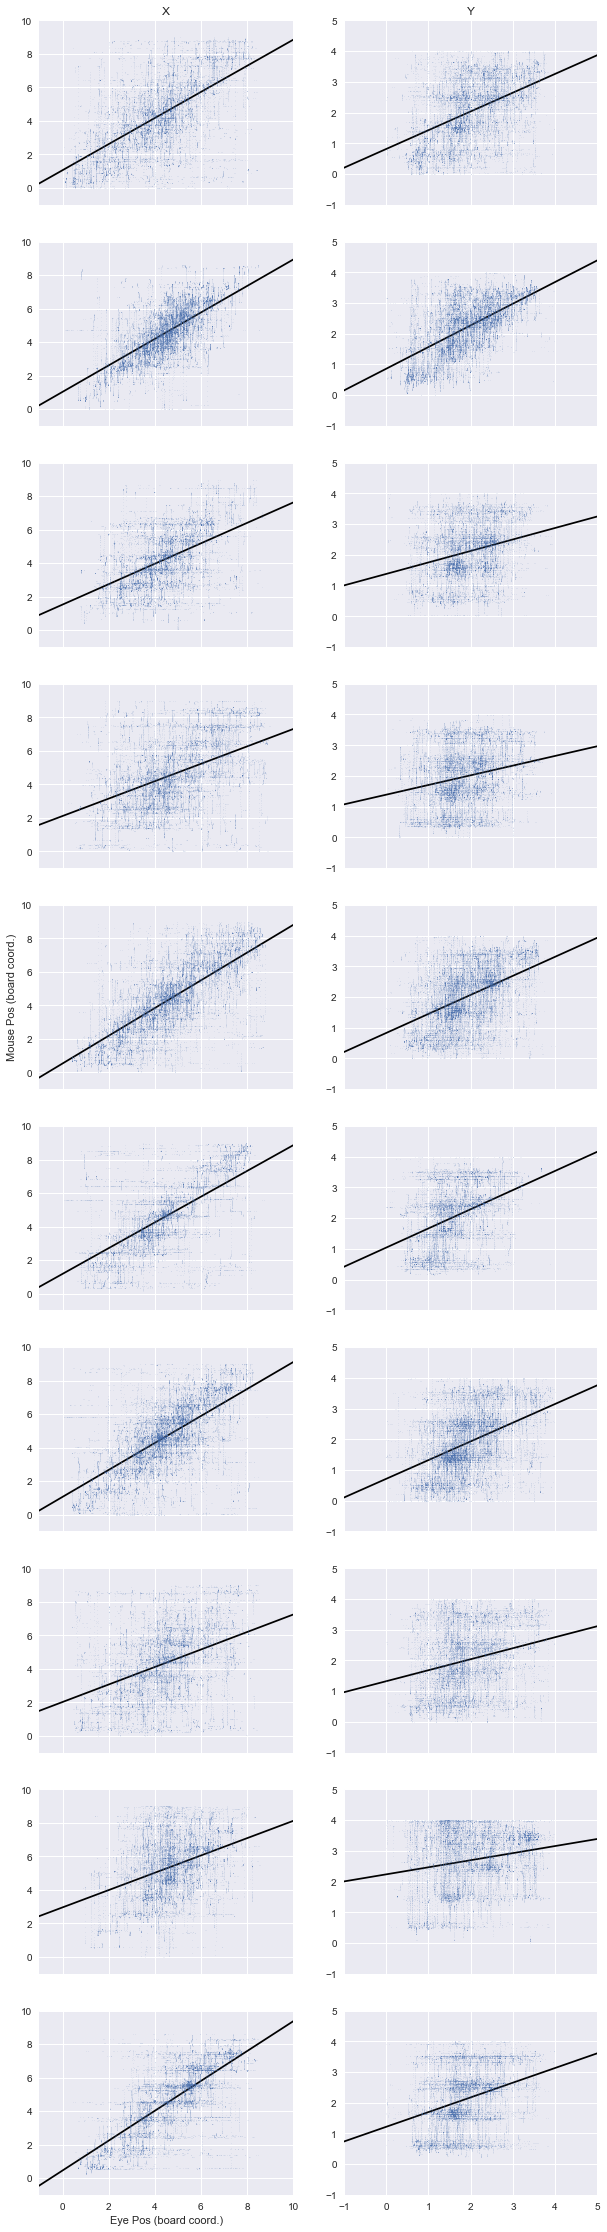

In [30]:
figrows = len(e_list)                                       # n rows == n subjects
fig, axes = plt.subplots(figrows, 2, figsize=(10, 40))   # initialize figure
scatterkws = {'linestyle': 'none', 'marker': 'o', 'markersize': 1, 'alpha': .1}
                                                            # set kws for scatter plot
xrs = []                                                    # initialize lists for x and y r values (convert to numpy?)
yrs = []
for subject, ee in enumerate(e_list):                       # for every subject
    for j, dim in enumerate(['x', 'y']):                    # for x and y dimensions      
        ul = 4 if dim=='y' else 9
        t_ = t[subject]                                     # select subject data
        nanfilter = pd.notnull(t_['eye' + dim]) & pd.notnull(t_['mou' + dim])
                                                            # filter records without mouse and eye vals
        trialfilter = t[subject]['task']=='playing'         # filter convenience records
        tt = t[subject].loc[nanfilter & trialfilter]        # apply filters
        eyebounds = (tt['eye' + dim] >= 0) & (tt['eye' + dim] <= ul)
        mousebounds = (tt['mou' + dim] >= 0) & (tt['mou' + dim] <= ul)
                                                            # filter eye  and mousecoordinates off board
        tt = tt.loc[eyebounds & mousebounds]                # apply eyebounds and mousebounds filters
        lr = stats.linregress(tt['eye' + dim], tt['mou' + dim])
                                                            # regress eye coordinate against mouse coordinate
        
        if dim == 'x':                                        # save regression coefficients
            xrs.append(lr.rvalue)
        else:
            yrs.append(lr.rvalue)
             
        ax = axes[subject, j]                               # select axes
        linex = [-2, 11]
        liney = [-2*lr.slope + lr.intercept, 11*lr.slope + lr.intercept]
                                                            # x and y coordinates for plotting regression line
        ax.plot(linex, liney, color='black')                # plot regression line
        ax.plot(tt['eye' + dim], tt['mou' + dim], **scatterkws)
                                                            # scatter eye coordinates against mouse coordinates

        
plt.setp(axes[:, 0], xlim=[-1, 10], ylim=[-1, 10])          # plot formatting
plt.setp(axes[:, 1], xlim=[-1, 5], ylim=[-1, 5])
plt.setp(axes[:-1, :], xticklabels=[])
plt.setp(axes[-1, 0], xlabel='Eye Pos (board coord.)')
plt.setp(axes[4, 0], ylabel='Mouse Pos (board coord.)')
plt.setp(axes[0, 0], title='X')
plt.setp(axes[0, 1], title='Y')

sns.despine()

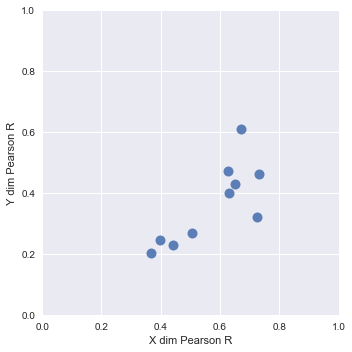

In [29]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
scatterkws['markersize'] = 10
scatterkws['alpha'] = .9
axes.plot(xrs, yrs, **scatterkws)
plt.setp(axes, xlabel='X dim Pearson R', ylabel='Y dim Pearson R', xlim=[0, 1], ylim=[0, 1])

sns.despine()
plt.tight_layout()

## Old stuff from debugging

In [30]:
_t = m.loc[m['turn'].isin([117,118,119])]
_t

,x,y,subject,human,turn,turnstart,turnend,ts,xtile,ytile,tile,dur,is human


In [31]:
g.loc[g.status.isin(['playing', 'draw', 'win'])].sort_index().head(30)

,idx,id,color,gi,mi,status,bp,wp,zet,rt,mt,mx,subject,human,tstemp,is human,turn
ts,,,,,,,,,,,,,,,,,
1.429887e+12,39,1429887330000,0,0,1,playing,000000000000000000000000000000000000,000000000000000000000000000000000000,11,4910,"1429887492293,1429887493138,1429887493141,1429...","477,382;477,382;477,383;477,385;477,386;477,38...",VL,9,0.000000e+00,1,1
1.429888e+12,40,18,1,0,2,playing,000000000001000000000000000000000000,000000000000000000000000000000000000,13,0,None,None,VL,9,1.429888e+12,0,2
1.429888e+12,41,1429887330000,0,0,3,playing,000000000001000000000000000000000000,000000000000010000000000000000000000,12,16103,"1429887503050,1429887497208,1429887497782,1429...","384,311;384,311;387,315;390,316;391,317;394,31...",VL,9,0.000000e+00,1,3
1.429888e+12,42,18,1,0,4,playing,000000000001100000000000000000000000,000000000000010000000000000000000000,27,0,None,None,VL,9,1.429888e+12,0,4
1.429888e+12,43,1429887330000,0,0,5,playing,000000000001100000000000000000000000,000000000000010000000000000100000000,21,19539,"1429887522399,1429887519157,1429887519861,1429...","452,309;452,309;451,309;450,310;450,311;448,31...",VL,9,0.000000e+00,1,5
1.429888e+12,44,18,1,0,6,playing,000000000001100000000100000000000000,000000000000010000000000000100000000,16,0,None,None,VL,9,1.429888e+12,0,6
1.429888e+12,45,1429887330000,0,0,7,playing,000000000001100000000100000000000000,000000000000010010000000000100000000,30,18794,"1429887543678,1429887541942,1429887543397,1429...","449,396;449,396;450,395;449,395;449,393;449,39...",VL,9,0.000000e+00,1,7
1.429888e+12,46,18,1,0,8,playing,000000000001100000000100000000100000,000000000000010010000000000100000000,3,0,None,None,VL,9,1.429888e+12,0,8
1.429888e+12,47,1429887330000,0,0,9,playing,000000000001100000000100000000100000,000100000000010010000000000100000000,31,9913,"1429887564855,1429887562475,1429887565509,1429...","467,468;467,468;466,466;467,466;469,466;470,46...",VL,9,0.000000e+00,1,9


In [32]:
gt = g.loc[g.status.isin(['playing', 'draw', 'win'])&g['is human']==1].set_index('turn')
mpvt.loc[gt.index, 'true rt'] = gt['rt']
mpvt['rt'] - mpvt['true rt']

turn
1.0       0.0
3.0       0.0
5.0       0.0
7.0       0.0
9.0       0.0
11.0      0.0
102.0     0.0
104.0     0.0
106.0     0.0
108.0     0.0
110.0     0.0
201.0     0.0
203.0     0.0
205.0     0.0
207.0     0.0
302.0     0.0
304.0     0.0
306.0     0.0
308.0     0.0
401.0     0.0
403.0     0.0
405.0     0.0
407.0     0.0
502.0     0.0
504.0     0.0
506.0     0.0
508.0     0.0
510.0     0.0
512.0     0.0
514.0     0.0
         ... 
1203.0    0.0
1205.0    0.0
1207.0    0.0
1209.0    0.0
1211.0    0.0
1213.0    0.0
1215.0    0.0
1217.0    0.0
1219.0    0.0
1221.0    0.0
1223.0    0.0
1225.0    0.0
1302.0    0.0
1304.0    0.0
1306.0    0.0
1308.0    0.0
1310.0    0.0
1312.0    0.0
1314.0    0.0
1316.0    0.0
1318.0    0.0
1320.0    0.0
1322.0    0.0
1324.0    0.0
1326.0    0.0
1328.0    0.0
1330.0    0.0
1332.0    0.0
1334.0    0.0
1336.0    0.0
dtype: float64

In [33]:
g = g_list[0]
g = g.loc[g['status']=='playing']
m = m_list[0]

probe = g.loc[(g['gi']==1)&(g['mi']==2), :]

endtime = probe.index.values[0]
starttime = endtime - probe['rt'].values[0]
print(endtime, starttime)
mp = m.loc[(m.index>=starttime)&(m.index<=endtime), ['x', 'y']].astype(float)
mp['tstemp'] = mp.index
mp['dur'] = -mp['tstemp'].diff(periods=-1)
mp['dur'].sum()

1.42929435904e+12 1.42929435654e+12


2491.0

In [34]:
# mt = np.array([str(starttime)] + probe['mt'].values[0].split(',') + [str(endtime)]).astype(float)
mt = np.array(probe['mt'].values[0].split(',')).astype(float)
mt = mt[mt >= starttime]
(mt[1:] - mt[:-1]).sum()

2500.0

In [35]:
probe['rt']

ts
1.429294e+12    2500
Name: rt, dtype: int64